## Load + process data

In [1]:
import matlab.engine
eng = matlab.engine.start_matlab()
eng.cd("./SSC_ADMM_v1.1")

'C:\\Users\\aleks_000\\Desktop\\Mentorship\\!GitHub'

In [2]:
# I renamed files 1, 2.. to 01, 02..
# so that they are globbed in order later

from pathlib import Path
def rename_Coil20(path="./data/coil-20-proc"):
    path = Path(path)
    for img in path.glob("obj*.png"):
        name = img.name
        new_name = name
        
        if(name.find('__') < 5):
            new_name = new_name[:3] + '0' + new_name[3:]
        if(len(new_name) < 13):
            new_name = new_name[:7] + '0' + new_name[7:]
        if(new_name != name):
            print("Renamed " + name + " to " + new_name)
            img.rename(path / new_name)

rename_Coil20()

In [3]:
from load import load_Coil20

images_raw, labels = load_Coil20()


Loading Coil20...
----------------
Elapsed: 0.63 sec


In [4]:
data_h = 32
data_w = 32

In [5]:
import numpy as np
from skimage.transform import resize

images_compressed = np.moveaxis(resize(np.moveaxis(images_raw, 0, -1), output_shape=(32, 32),
                                       order=1, mode='reflect', anti_aliasing=True), -1, 0)

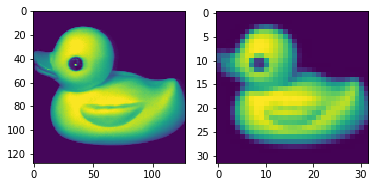

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)

ax[0].imshow(images_raw[0]);
ax[1].imshow(images_compressed[0]);

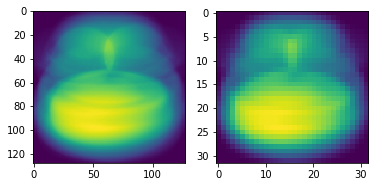

In [7]:
fig, ax = plt.subplots(1, 2)
idx = 0

ax[0].imshow(np.mean(images_raw[72*idx:72*(idx+1)], axis=0));
ax[1].imshow(np.mean(images_compressed[72*idx:72*(idx+1)], axis=0));

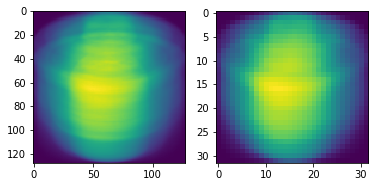

In [8]:
fig, ax = plt.subplots(1, 2)

ax[0].imshow(np.mean(images_raw, axis=0));
ax[1].imshow(np.mean(images_compressed, axis=0));

In [9]:
from visualize import tSNE_2D, tSNE_3D

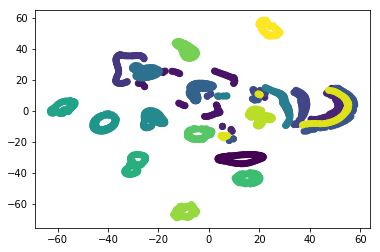

In [10]:
images_raw_flat = images_raw.reshape(images_raw.shape[0], -1)
images_compressed_flat = images_compressed.reshape(images_compressed.shape[0], -1)
tSNE_2D(images_compressed_flat, labels)
#tSNE_3D(images_compressed_flat, labels)

## Normalize data

In [11]:
inpt = images_compressed_flat

# global rescale to [-1, 1]
mmin = np.min(inpt)
mmax = np.max(inpt)
images_norm = (np.multiply(inpt, 2, dtype='float64') - mmax - mmin) / (mmax - mmin)

In [12]:
from load import split

if('images_norm_val' not in locals()):
    images_norm_val, images_norm = split(images_norm, 0.2)
    labels_val, labels = split(labels, 0.2)

In [13]:
# from scipy.io import savemat

# savemat('./saved/raw/Coil20.mat', mdict={'X':images_raw, 'Y':labels})
# savemat('./saved/rescaled/Coil20.mat', mdict={'X':images_norm, 'Y':labels, 'X_val':images_norm_val, 'Y_val':labels_val})

## Calculate C matrix

In [14]:
import numpy as np
import supporting_files.sda as sda

from supporting_files.helpers import optimize
from scipy.io import savemat, loadmat

In [353]:
# Matlab SSC #1
savemat('./temp.mat', mdict={'X': images_norm})
k = len(np.unique(labels))
alpha = 10.0
maxIter = 63
eng.SSC_modified(k, 0, False, alpha, False, 1, 1e-20, maxIter, False, 0)
C = loadmat("./temp.mat")['C']

0.0 0.7719051512537459
0.00021088613677714433


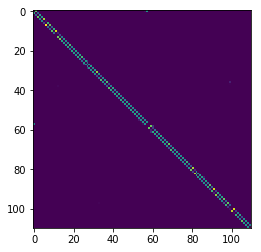

In [309]:
display_image(C[:110, :110], 110, 110)
print(np.mean(np.square(C)))

0.08756962308829781


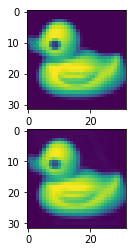

In [310]:
fig, ax = plt.subplots(2)

index = 0;
ax[0].imshow(images_norm[index].reshape((data_h, data_w)));
ax[1].imshow(np.matmul(C, images_norm)[index].reshape((data_h, data_w)));
print(np.mean(np.square(images_norm - np.matmul(C, images_norm))))

## Train Autoencoder

In [357]:
from supporting_files import helpers
from supporting_files import sda
import dsc
import importlib
importlib.reload(helpers)
importlib.reload(sda)
importlib.reload(dsc)

<module 'dsc' from 'C:\\Users\\aleks_000\\Desktop\\Mentorship\\!GitHub\\dsc.py'>

In [ ]:
%%time
trainC = False
C = None
d = dsc.DeepSubspaceClustering(images_norm, images_norm_val, C=C, trainC=trainC, hidden_dims=[32], weight_init='sda-normal',
                               weight_init_params={'epochs_max':10000, 'sda_printstep':100, 'validation_step':10}, lr=0.001, batch_num=1,
                               sda_optimizer='Adam', sda_decay='none', verbose=False, save_path="./saved/models/coil20/test_{0:.4g}")

In [358]:
%%time
trainC = True
C = C
d = dsc.DeepSubspaceClustering(images_norm, images_norm_val, C=C, trainC=trainC, hidden_dims=[32],
                               lr=0.001, batch_num=1, seed=0, verbose=True, load_path="./saved/models/coil20/test_0.1699")


Model loaded from ./saved/models/coil20/test_0.1699.npz
Wall time: 107 ms


In [359]:
encoded_h = 4
encoded_w = 8

In [361]:
%%time
sess = d.train(lambda1=0.0, lambda2=0.0, lambda3=0.0, learning_rate=0.00001, optimizer='Adam', decay='none',
               batch_num=100, epochs=1000, print_step=10, validation_step=1, stop_criteria=5)
images_HM2 = d.result
images_HM = d.reconstr
if(trainC):
    trained_C = np.float64(d.outC)
else:
    trained_C = C

C:\Program Files\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


epoch 0: global loss = 0.08128371834754944
epoch 0: validation loss = 0.0414353609085083
epoch 1: validation loss = 0.0404830127954483
epoch 2: validation loss = 0.04013458266854286
epoch 3: validation loss = 0.03948764130473137
epoch 4: validation loss = 0.03904663771390915
epoch 5: validation loss = 0.03845808655023575
epoch 6: validation loss = 0.038262657821178436
epoch 7: validation loss = 0.03784599155187607
epoch 8: validation loss = 0.03760118782520294
epoch 9: validation loss = 0.0373380184173584
epoch 10: global loss = 0.04959498345851898
epoch 10: validation loss = 0.03724245727062225
epoch 11: validation loss = 0.037024274468421936
epoch 12: validation loss = 0.03692026436328888
epoch 13: validation loss = 0.03685463219881058
epoch 14: validation loss = 0.036768801510334015
epoch 15: validation loss = 0.03676505386829376
epoch 16: validation loss = 0.03676941618323326
epoch 17: validation loss = 0.036780014634132385
epoch 18: validation loss = 0.036680273711681366
epoch 19:

In [362]:
import matplotlib.pyplot as plt

def display_image(image, height, width):
    print(np.min(image), np.max(image))
    imgplot = plt.imshow(image.reshape((height, width)))

-0.002422324614599347 0.7697238922119141


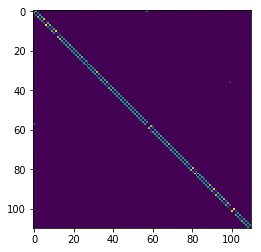

In [363]:
# lambda3 - regularization on trained_C
if(trained_C is not None):
    display_image(trained_C[:110, :110], 110, 110)

-0.98608786 0.966582


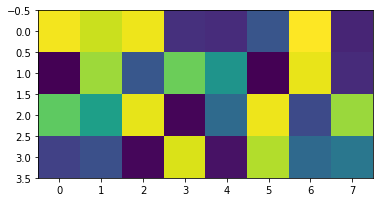

In [364]:
display_image(images_HM2[0], encoded_h, encoded_w)

-1.4531783633004591 1.2670845647980435
0.05431303177422682


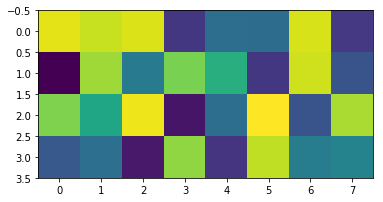

In [365]:
# lambda1 - self-expressiveness
if(C is not None):
    display_image(np.matmul(trained_C, images_HM2)[0], encoded_h, encoded_w)
    print(np.mean(np.square(images_HM2 - np.matmul(trained_C, images_HM2))))

-0.9009154 0.7804193


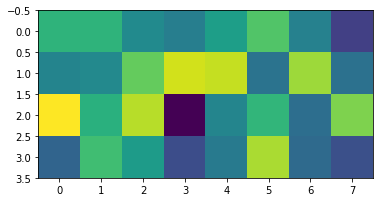

In [366]:
display_image(np.mean(images_HM2, axis=0), encoded_h, encoded_w)

0.124566495 0.8272045


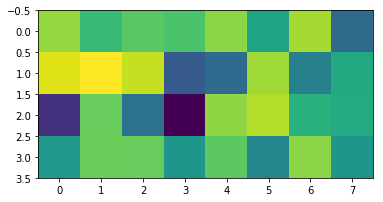

In [367]:
display_image(np.std(images_HM2, axis=0), encoded_h, encoded_w)

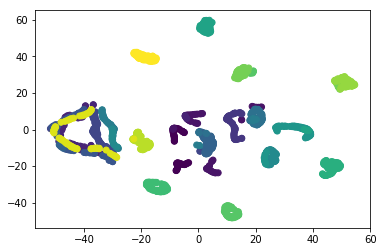

In [368]:
tSNE_2D(images_HM2, labels)
# tSNE_3D(images_HM2, labels)

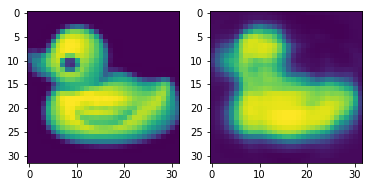

In [369]:
# AE Reconstruction
fig, ax = plt.subplots(1, 2)

index = 0;
ax[0].imshow(images_norm[index].reshape((data_h, data_w)));
ax[1].imshow(images_HM[index].reshape((data_h, data_w)));

By rows (original): [0.21070576 0.37507029 0.47828121 0.52673378 0.53858429 0.55311359
 0.55957941 0.55592714 0.55144535 0.53691736 0.51993584 0.50925615
 0.49707679 0.48054116 0.46252388 0.45322134 0.43410843 0.43857033
 0.4525364  0.46072733 0.47988372 0.50206936 0.50875808 0.50575866
 0.49250807 0.46881216 0.44076242 0.42026334 0.40428605 0.37396891
 0.31478717 0.18205156]
By rows (AE reconstr): [0.15623465 0.29776332 0.38700908 0.43322474 0.43998706 0.45181602
 0.4637972  0.46427053 0.45914382 0.44465077 0.4318176  0.4180699
 0.4024732  0.38276786 0.3624842  0.3494597  0.33476782 0.34315285
 0.3621995  0.377972   0.3994414  0.42017272 0.43269867 0.43038136
 0.41811267 0.39478028 0.36465156 0.34905282 0.3346535  0.30818012
 0.25400347 0.13279152]


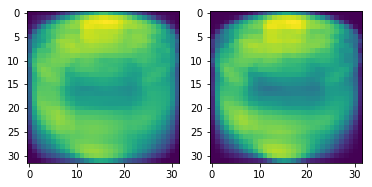

In [370]:
fig, ax = plt.subplots(1, 2)

ax[0].imshow(np.std(images_norm, axis=0).reshape((data_h, data_w)));
ax[1].imshow(np.std(images_HM, axis=0).reshape((data_h, data_w)));
print("By rows (original):", np.mean(np.std(images_norm, axis=0).reshape((data_h, -1)), axis=1))
print("By rows (AE reconstr):", np.mean(np.std(images_HM, axis=0).reshape((data_h, -1)), axis=1))

In [371]:
# Orthogonalize HM2 with PCA
from sklearn.decomposition import PCA
import numpy as np

pca2 = PCA(n_components=30, whiten=False, svd_solver='arpack', random_state=0)
images_HM2_orth = pca2.fit_transform(images_HM2)

images_HM2_orth.shape

(1152, 30)

0.20894454 1.5054283
By rows: [1.0958544  0.6749368  0.47932833 0.38420817 0.3141525  0.25347835]


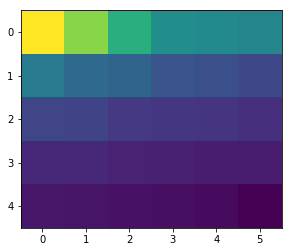

In [372]:
stds2 = np.std(images_HM2_orth, axis=0)
display_image(stds2, 5, 6)
print("By rows:", np.mean(stds2.reshape((6, -1)), axis=1))

In [373]:
np.std(images_HM2_orth, axis=0)[1] / np.std(images_HM2_orth, axis=0)[0]

0.8469385

In [378]:
# AE Features (orthogonalized)
from ipywidgets import BoundedIntText, FloatSlider, Output, VBox
idx = BoundedIntText(description="Index:", max=images_HM2_orth.shape[1]-1)
val = FloatSlider(description="Value:", continuous_update=False)
output = Output()

indx = 1000
vector = images_HM2_orth[indx:indx+1].copy()
val_mins = (np.mean(images_HM2_orth, axis=0) - 2 * np.std(images_HM2_orth, axis=0)).flatten()
val_maxs = (np.mean(images_HM2_orth, axis=0) + 2 * np.std(images_HM2_orth, axis=0)).flatten()

def update_channels(change):
    val.min = val_mins[change.new]
    val.max = val_maxs[change.new]
    val.step = (val_maxs[change.new] - val_mins[change.new]) / 100
    val.value = vector[0][change.new]
idx.observe(update_channels, 'value')

def update_plot(change):
    if(change is not None):
        vector[0][idx.value] = change.new
    output.clear_output(wait=True)
    with output:
        plt.imshow(vector[0].reshape((5, 6)))
        plt.show()
        out = sess.run(d.H_M, feed_dict={d.H_M_2_post: pca2.inverse_transform(vector)})
        plt.imshow(out.reshape((data_h, data_w)))
        plt.show()
val.observe(update_plot, 'value')

update_channels(type('obj', (object,), {'new': 0}))
VBox([idx, val, output])

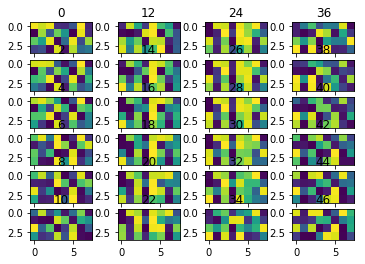

In [375]:
# HM2 Rotation
fig, ax = plt.subplots(6, 4)

for i in range(24):
    ax[i%6][i//6].imshow(images_HM2[2*i].reshape((encoded_h, encoded_w)));
    ax[i%6][i//6].set_title(2*i)

In [90]:
# Matlab SSC #2
k = len(np.unique(labels))
alpha = 20.0
maxIter = 63
if(not trainC):
    savemat('./temp.mat', mdict={'X': images_HM2})
else:
    savemat('./temp.mat', mdict={'C': trained_C})
grps = eng.SSC_modified(k, 0, False, alpha, False, 1, 1e-20, maxIter, True, 0, trainC)
C_after = loadmat("./temp.mat")['C']
labels_pred = np.asarray(grps, dtype=np.int32).flatten()

In [91]:
from ipywidgets import IntSlider, Output, VBox
sld_x = IntSlider(description="X:", max=C_after.shape[1]-110, continuous_update=True)
sld_y = IntSlider(description="Y:", max=C_after.shape[0]-110, continuous_update=True)
output = Output()

def update_C(change):
    output.clear_output(wait=True)
    with output:
        plt.imshow(C_after[sld_y.value:sld_y.value+110, sld_x.value:sld_x.value+110].reshape((110, 110)))
        plt.show()
sld_x.observe(update_C, 'value')
sld_y.observe(update_C, 'value')

update_C(None)
VBox([sld_x, sld_y, output])

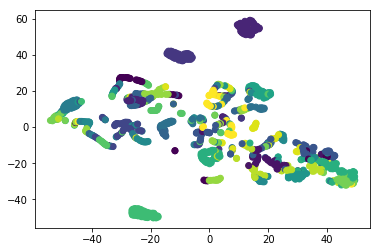

In [92]:
tSNE_2D(images_HM2, labels_pred)
# tSNE_3D(images_HM2, labels_pred)

## Perform clustering with SSC

In [160]:
from supporting_files.ji_zhang import err_rate
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import adjusted_rand_score as ari

predicted = labels_pred
print("Accuracy: ", str(1-err_rate(labels, predicted)))
print("NMI: ", str(nmi(labels, predicted, average_method="geometric")))
print("ARI: ", str(ari(labels, predicted)))

Accuracy:  0.45572916666666663
NMI:  0.5242160872529921
ARI:  0.3102841982392311


In [158]:
import sys
from sklearn.cluster import SpectralClustering
# sc = SpectralClustering(n_clusters=20, random_state=0)
# labels_pred2 = sc.fit_predict(images_HM2, labels)
sc = SpectralClustering(n_clusters=20, random_state=0, affinity='precomputed')
labels_pred2 = sc.fit_predict(C_after, labels)

C:\Program Files\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:883: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


# Presentation stuff

In [450]:
import itertools

def hypercube(n=100, d=2):
    points = np.random.uniform(size=(n, d))
    dists = [np.linalg.norm(a-b) for a, b in itertools.combinations(points, 2)]
    ma = max(dists)
    mi = min(dists)
    print(ma, mi, ma / mi)

In [465]:
hypercube(d=1000000)

409.1017391337275 407.4700341469467 1.0040044784893123


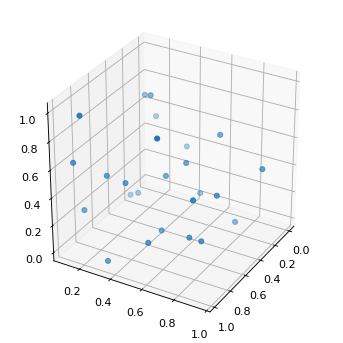

In [437]:
from mpl_toolkits.mplot3d import Axes3D

n = 25
fig = plt.figure(figsize=(4, 4), dpi=80)
ax = Axes3D(fig)
ax.view_init(azim=30)
scatter = ax.scatter(np.random.uniform(size=n), np.random.uniform(size=n), np.random.uniform(size=n))

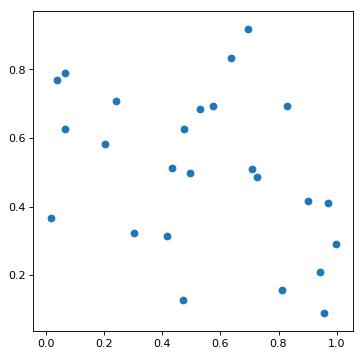

In [443]:
n = 25
fig = plt.figure(figsize=(4, 4), dpi=80)
ax = fig.add_axes([0,0,1,1])
scatter = ax.scatter(np.random.uniform(size=n), np.random.uniform(size=n))

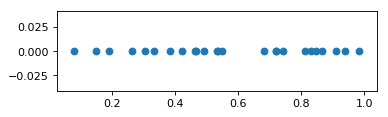

In [449]:
n = 25
fig = plt.figure(figsize=(4, 1), dpi=80)
ax = fig.add_axes([0,0,1,1])
scatter = ax.scatter(np.random.uniform(size=n), [0]*n)